In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
labels = ['Benign', 'Melanoma']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/skin_cancer_dataset/ISBI2016/train set',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/MyDrive/skin_cancer_dataset/ISBI2016/test set',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 75/75 [00:20<00:00,  3.60it/s]


In [4]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)

X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)
X_test.shape

(150, 224, 224, 3)

In [ ]:
X_train.shape

(900, 224, 224, 3)

<ipython-input-15-08a65a05fde0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


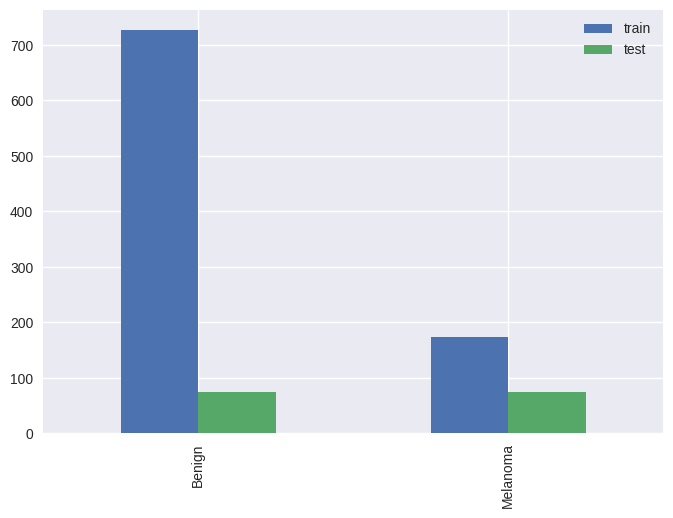

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset',dpi=400)
plt.show()

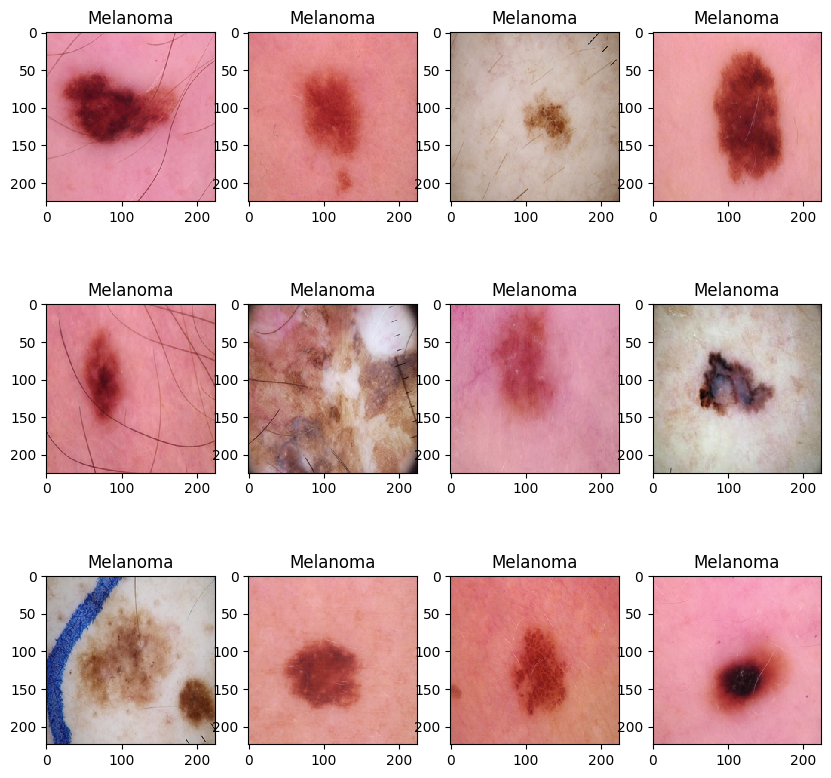

In [ ]:
plt.style.use('default')
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Melanoma')
    plt.imshow(X_train[i], interpolation='nearest')
plt.savefig('samples',dpi=400)
plt.show()

In [5]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
X_train = X_train.reshape(900,3*224*224)

In [ ]:
from imblearn.over_sampling import SMOTE
sm_train = SMOTE(random_state=42, sampling_strategy=1)
X_train, Y_train = sm_train.fit_resample(X_train, Y_train)
X_train.shape

(1454, 150528)

<ipython-input-22-7e668f9bd09a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


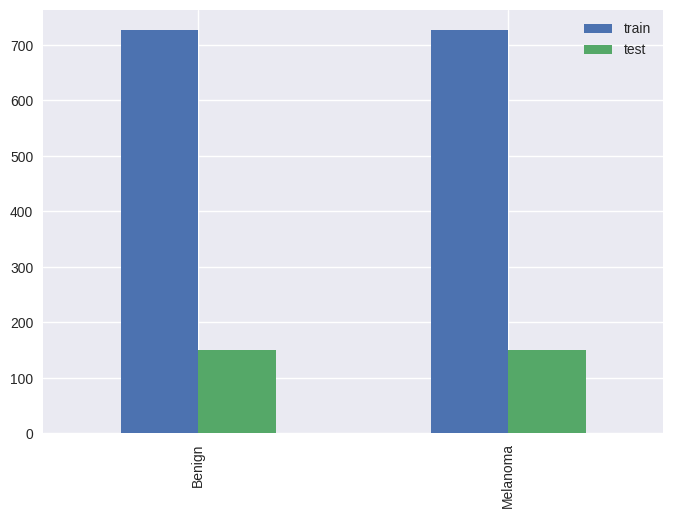

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset after smote1',dpi=400)
plt.show()

In [ ]:
X_train = X_train.reshape(1454,224,224,3)
Y_train = Y_train.reshape(1454,)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)

In [ ]:
X_train.shape

(810, 224, 224, 3)

In [ ]:
X_val.shape

(90, 224, 224, 3)

In [ ]:
X_test.shape

(150, 224, 224, 3)

<ipython-input-33-88cb42077ea9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


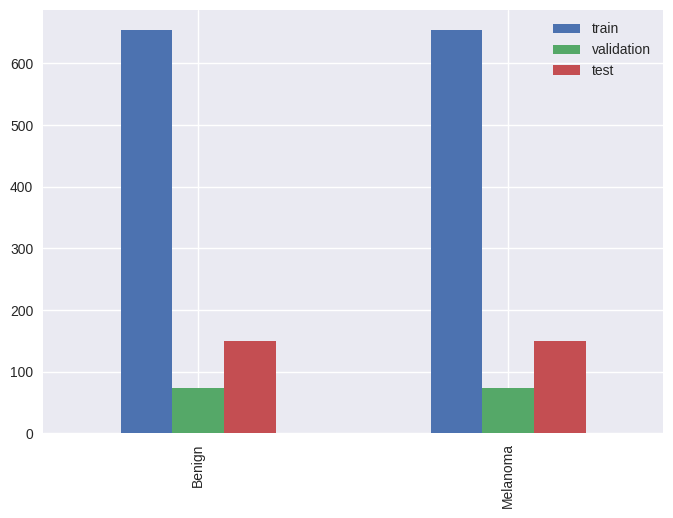

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, val_counts = np.unique(Y_val, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                  'validation': val_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset split',dpi=400)
plt.show()

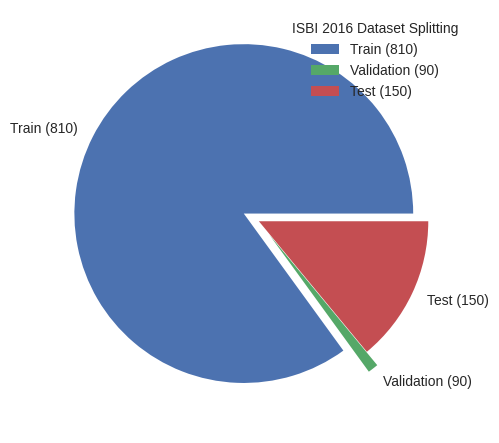

In [ ]:
import sys
y = np.array([85, 1, 14])
mylabels = ["Train (810)", "Validation (90)", "Test (150)"]
myexplode = [0.1, 0.1, 0]

plt.pie(y, labels = mylabels, explode = myexplode, shadow = False)
plt.legend(title = "ISBI 2016 Dataset Splitting")
plt.savefig('ratio data1',dpi=400)
plt.show()

In [7]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [8]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

incep = InceptionV3(include_top=False, input_shape=input_shape)(inputs)

87910968/87910968 [==============================] - 0s 0us/step


In [9]:
outputs = GlobalAveragePooling2D()(incep)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               524544

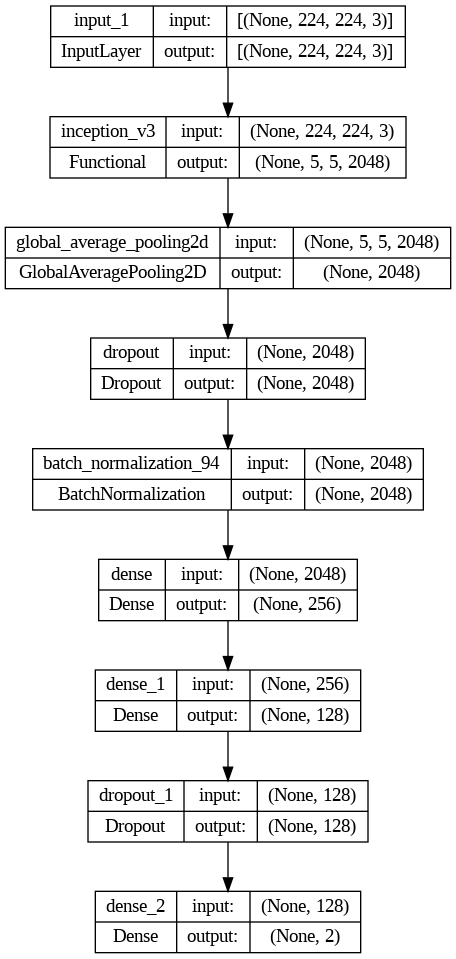

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='InceptionV3.png')

In [11]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/InceptionV3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [12]:
history = model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(X_val, Y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-12-854e9c4d3779>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
26/25 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8210

25/25 [==============================] - 68s 788ms/step - loss: 0.4323 - accuracy: 0.8210 - val_loss: 3310066.5000 - val_accuracy: 0.1556 - lr: 0.0010
Epoch 2/40
26/25 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9012

25/25 [==============================] - 12s 466ms/step - loss: 0.2854 - accuracy: 0.9012 - val_loss: 7914.9902 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 3/40
26/25 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.9160

25/25 [==============================] - 15s 571ms/step - loss: 0.2564 - accuracy: 0.9160 - val_loss: 16.4827 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/40
26/25 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9160

25/25 [==============================] - 17s 643ms/step - loss: 0.2185 - accuracy: 0.9160 - val_loss: 9431.9121 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 5/40
26/25 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9136

25/25 [==============================] - 14s 566ms/step - loss: 0.2606 - accuracy: 0.9136 - val_loss: 54340.6172 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/40
26/25 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9383

25/25 [==============================] - 13s 503ms/step - loss: 0.1607 - accuracy: 0.9383 - val_loss: 2836.1802 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 7/40
26/25 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9284

25/25 [==============================] - 14s 560ms/step - loss: 0.1627 - accuracy: 0.9284 - val_loss: 33.8612 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 8/40
26/25 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9173

25/25 [==============================] - 15s 572ms/step - loss: 0.2101 - accuracy: 0.9173 - val_loss: 0.1072 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 9/40
26/25 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9395

25/25 [==============================] - 13s 519ms/step - loss: 0.1502 - accuracy: 0.9395 - val_loss: 0.2743 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 10/40
26/25 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9432

25/25 [==============================] - 12s 463ms/step - loss: 0.1718 - accuracy: 0.9432 - val_loss: 0.1519 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 11/40
26/25 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9358

25/25 [==============================] - 14s 536ms/step - loss: 0.1783 - accuracy: 0.9358 - val_loss: 0.3127 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 12/40
26/25 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9432

25/25 [==============================] - 14s 555ms/step - loss: 0.1625 - accuracy: 0.9432 - val_loss: 0.2899 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 13/40
26/25 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9358

25/25 [==============================] - 14s 559ms/step - loss: 0.2064 - accuracy: 0.9358 - val_loss: 0.0804 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 14/40
26/25 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9247

25/25 [==============================] - 14s 563ms/step - loss: 0.2219 - accuracy: 0.9247 - val_loss: 0.2847 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 15/40
26/25 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9432

25/25 [==============================] - 14s 560ms/step - loss: 0.1581 - accuracy: 0.9432 - val_loss: 1.2874 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 16/40
26/25 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9284

25/25 [==============================] - 14s 557ms/step - loss: 0.1947 - accuracy: 0.9284 - val_loss: 9.2751 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 17/40
26/25 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9370

25/25 [==============================] - 14s 553ms/step - loss: 0.1853 - accuracy: 0.9370 - val_loss: 0.3343 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 18/40
26/25 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9457

25/25 [==============================] - 15s 566ms/step - loss: 0.1464 - accuracy: 0.9457 - val_loss: 0.1003 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 19/40
26/25 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9321

25/25 [==============================] - 13s 509ms/step - loss: 0.2118 - accuracy: 0.9321 - val_loss: 51.3634 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 20/40
26/25 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9531

25/25 [==============================] - 14s 559ms/step - loss: 0.1498 - accuracy: 0.9531 - val_loss: 4.6833 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 21/40
26/25 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9395

25/25 [==============================] - 14s 559ms/step - loss: 0.1698 - accuracy: 0.9395 - val_loss: 0.1456 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 22/40
26/25 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9346

25/25 [==============================] - 14s 536ms/step - loss: 0.2272 - accuracy: 0.9346 - val_loss: 54.9213 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 23/40
26/25 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9370

25/25 [==============================] - 14s 558ms/step - loss: 0.1753 - accuracy: 0.9370 - val_loss: 10.3798 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 24/40
26/25 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9444

25/25 [==============================] - 13s 498ms/step - loss: 0.1552 - accuracy: 0.9444 - val_loss: 0.7088 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 25/40
26/25 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9457

25/25 [==============================] - 14s 554ms/step - loss: 0.1377 - accuracy: 0.9457 - val_loss: 0.0789 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 26/40
26/25 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9531

25/25 [==============================] - 12s 467ms/step - loss: 0.1315 - accuracy: 0.9531 - val_loss: 0.5074 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 27/40
26/25 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9568

25/25 [==============================] - 14s 518ms/step - loss: 0.0920 - accuracy: 0.9568 - val_loss: 0.4764 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 28/40
26/25 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9580

25/25 [==============================] - 14s 564ms/step - loss: 0.0975 - accuracy: 0.9580 - val_loss: 0.4505 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 29/40
26/25 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9580

25/25 [==============================] - 14s 563ms/step - loss: 0.1073 - accuracy: 0.9580 - val_loss: 0.1580 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 30/40
26/25 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9556

25/25 [==============================] - 14s 536ms/step - loss: 0.1215 - accuracy: 0.9556 - val_loss: 0.0273 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 31/40
26/25 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9432

25/25 [==============================] - 13s 498ms/step - loss: 0.1182 - accuracy: 0.9432 - val_loss: 0.0641 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 32/40
26/25 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9494

25/25 [==============================] - 14s 558ms/step - loss: 0.1034 - accuracy: 0.9494 - val_loss: 0.0622 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 33/40
26/25 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9580

25/25 [==============================] - 12s 484ms/step - loss: 0.1130 - accuracy: 0.9580 - val_loss: 0.5617 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 34/40
26/25 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9519

25/25 [==============================] - 14s 559ms/step - loss: 0.1275 - accuracy: 0.9519 - val_loss: 0.1331 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 35/40
26/25 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9395

25/25 [==============================] - 14s 572ms/step - loss: 0.1659 - accuracy: 0.9395 - val_loss: 0.2134 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 36/40
26/25 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9519

25/25 [==============================] - 13s 529ms/step - loss: 0.1197 - accuracy: 0.9519 - val_loss: 0.3212 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 37/40
26/25 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9667

25/25 [==============================] - 14s 546ms/step - loss: 0.1000 - accuracy: 0.9667 - val_loss: 0.1059 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 38/40
26/25 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9568

25/25 [==============================] - 14s 557ms/step - loss: 0.1424 - accuracy: 0.9568 - val_loss: 0.4386 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 39/40
26/25 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9568

25/25 [==============================] - 13s 514ms/step - loss: 0.1078 - accuracy: 0.9568 - val_loss: 0.2399 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 40/40
26/25 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9556

25/25 [==============================] - 12s 473ms/step - loss: 0.1213 - accuracy: 0.9556 - val_loss: 0.0921 - val_accuracy: 0.9889 - lr: 0.0010


<ipython-input-13-2c0c276ff035>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


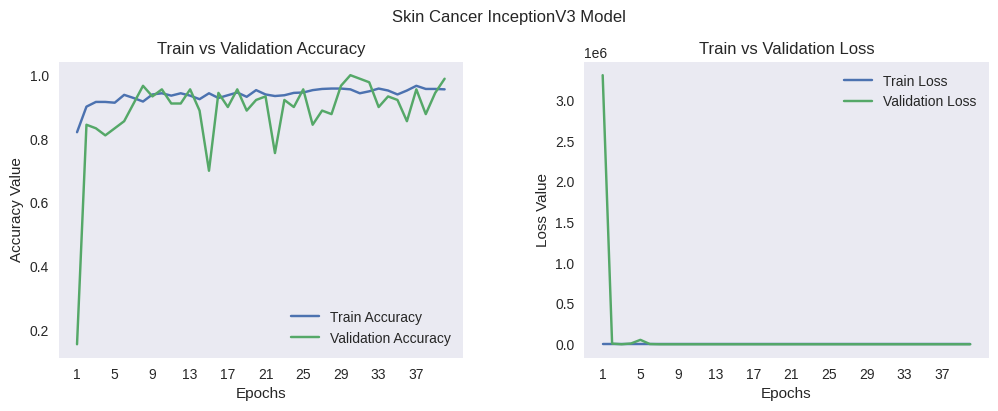

In [13]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Skin Cancer InceptionV3 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epochs')
ax1.set_title('Train vs Validation Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epochs')
ax2.set_title('Train vs Validation Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve',dpi=400)

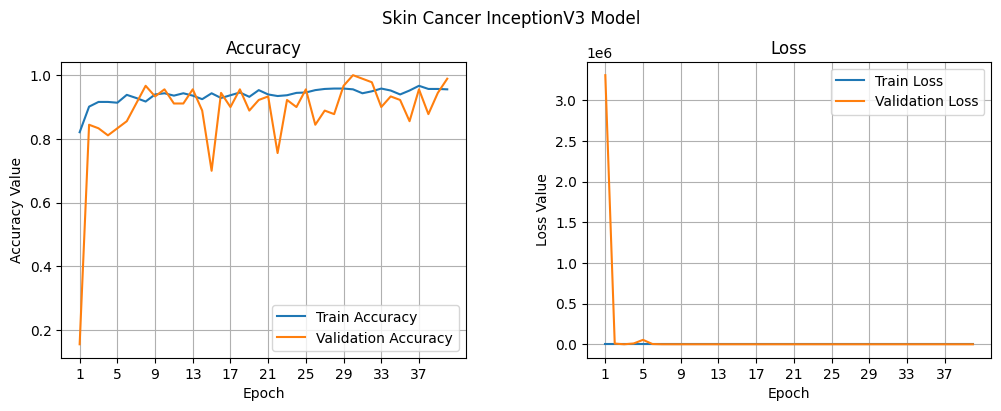

In [14]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Skin Cancer InceptionV3 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)
print(classification_report(y_test_new,pred))

5/5 [==============================] - 3s 458ms/step
              precision    recall  f1-score   support

           0       0.72      0.97      0.83        75
           1       0.96      0.63      0.76        75

    accuracy                           0.80       150
   macro avg       0.84      0.80      0.79       150
weighted avg       0.84      0.80      0.79       150



Confusion matrix, without normalization
[[73  2]
 [28 47]]


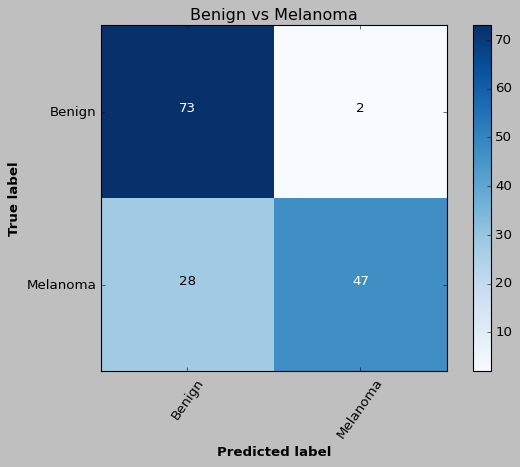

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test_new,pred)

cm_plot_label =['Benign', 'Melanoma']
plot_confusion_matrix(cm, cm_plot_label, title ='Benign vs Melanoma')
plt.savefig('CM',dpi=400)

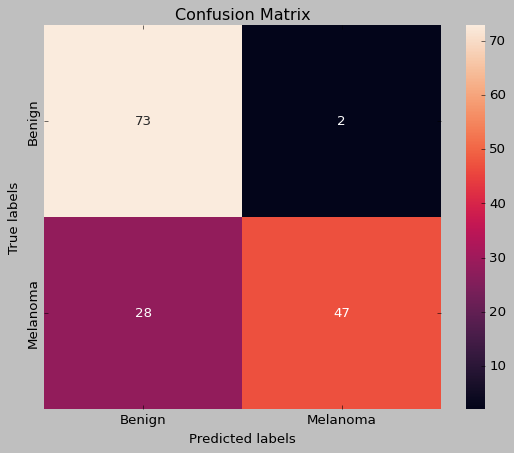

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Benign', 'Melanoma']); ax.yaxis.set_ticklabels(['Benign', 'Melanoma'])
plt.savefig('CM_heatmap',dpi=400)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,matthews_corrcoef,cohen_kappa_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred),
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred),'MCC: %.3f' % matthews_corrcoef(y_test_new, pred),
      'Kappa: %.3f' % cohen_kappa_score(y_test_new, pred))

Accuracy: 0.800 Precision: 0.959  Recall: 0.627 F1 Score: 0.758 AUC Score: 0.800 MCC: 0.640 Kappa: 0.600


In [19]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 47.000000 TN: 73.000000 FP: 2.000000 FN: 28.000000


In [20]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.3f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.3f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.3f' % f1)
print( 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

print('MCC: %.3f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.3f' % cohen_kappa_score(y_test_new, pred))

Specificity: 0.973
 Recall: 0.627
 Precision: 0.959
F1 Score: 0.758
AUC Score: 0.800
Error Rate: 0.20000
MCC: 0.640 Kappa: 0.600


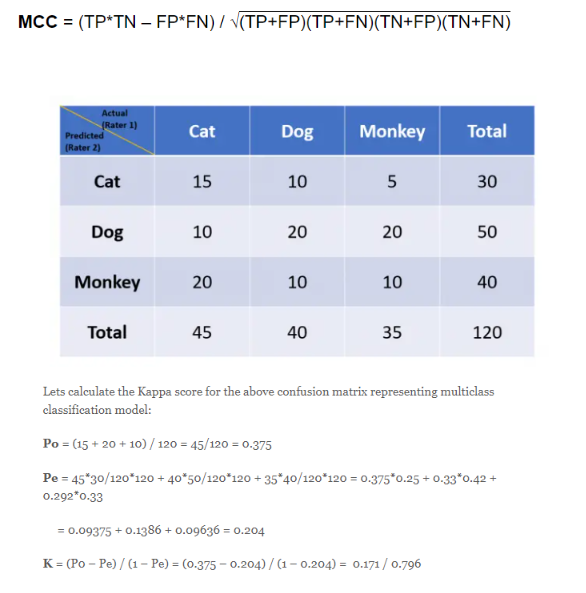

<ipython-input-21-473ee2f7a8a1>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


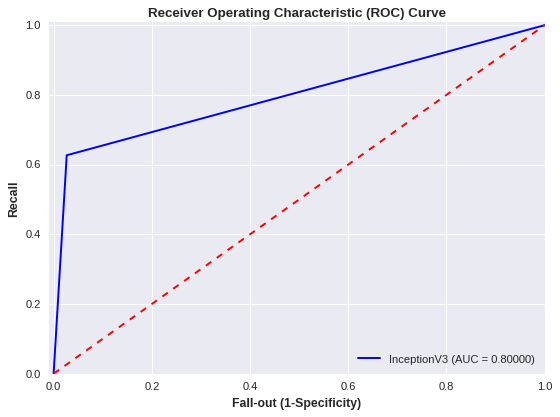

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'InceptionV3 (AUC = %0.5f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve',dpi=400)
plt.show()

In [22]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 80.00%
Precision: 95.92%
Recall or Sensitivity: 62.67%
Specificity: 97.33%
F1-score: 75.81%
AUC-score: 80.00%
Train acc: 95.56%


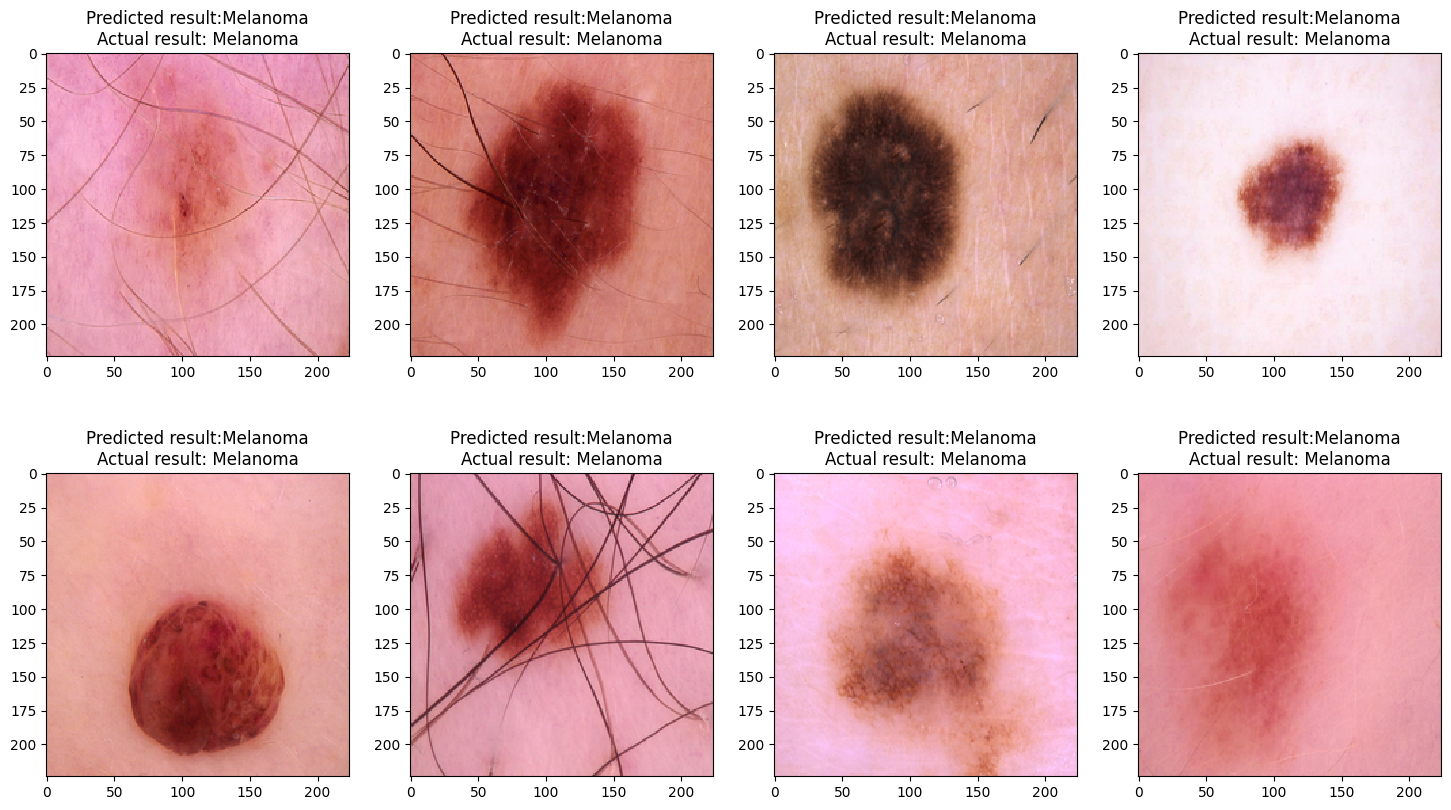

In [ ]:
plt.style.use('default')
i=0
prop_class=[]
mis_class=[]
#pred = np.argmax(pred,axis=1)
#y_test_new = np.argmax(Y_test,axis=1)
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Melanoma"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.savefig('prediction',dpi=400)
plt.show()